**This notebook is to parse out pdb file and bin residues on the surface of the protein**

In [1]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pylab as plt 
import pandas as pd 
import scipy
import sklearn
import itertools 
from itertools import cycle 
import os.path as op
import timeit 


# These imports are for creating the percent occupancy heat map 
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

### create occupancy file using mdtraj and other tools from the .gro and .xtc file... Output txt file after splitting trajectory

### Figure out how to setup ipyparallel for using multiple nodes 

In [ ]:
import ipyparallel as ipp

## connect to the client
ipyclient = ipp.Client(profile="MPI32")

## print how many engines are connected
print(len(ipyclient), 'cores')


### Below makes a plot with number of surface residues 

In [2]:
# Read in data from the oputput of wrapper.sh 
wat_data = pd.read_csv('occ_BSA1ns.txt', sep=" ", header=None, usecols=None ,index_col=None)
wat_data.columns = ["BSA_res_no","No. of frames"]
wat_data.head()

,BSA_res_no,No. of frames
0,1,1002
1,2,1002
2,3,1002
3,4,1002
4,5,1002


In [3]:
a_a = ["GLY","ALA","VAL","LEU","ILE","MET","PHE","TRP","PRO","SER","THR","CYS","TYR","ASN","GLN","ASP"
               ,"GLU","LYS","ARG","HIS"]

In [ ]:
import multiprocessing as m_proc
m_proc.cpu_count()

In [4]:
# Isolate each residue of bsa from pdb file(not in list method, 2nd draft, 70.72s run time) 

#start_time = timeit.default_timer()

red_bsa = []
for j in range(len(wat_data["BSA_res_no"])):
    for i in range(len(a_a)):
        st_r = str(" "+a_a[i]+"     "+str(j+1)+" ")
        st_r1 = str(" "+a_a[i]+"    "+str(j+1)+" ")
        st_r2 = str(" "+a_a[i]+"   "+str(j+1)+" ")
        for line in open("../BSA.pdb",'r'):
            if st_r in line:
                if len(red_bsa) == 0:
                    if st_r not in red_bsa:
                        l = line.splitlines()
                        red_bsa.append(l[0][16:27])
                elif len(red_bsa) != 0:
                    hj = len(red_bsa) - 1
                    if st_r not in red_bsa[hj]:
                        lb = line.splitlines()
                        red_bsa.append(lb[0][16:27])
            elif st_r1 in line:
                lj = len(red_bsa) - 1
                if st_r1 not in red_bsa[lj]:
                    b = line.splitlines()
                    red_bsa.append(b[0][16:27])     
            elif st_r2 in line:
                kj = len(red_bsa) - 1
                if st_r2 not in red_bsa[kj]:
                    r2 = line.splitlines()
                    red_bsa.append(r2[0][16:27]) 
                    
#timeit.default_timer() - start_time
#rb = [row[1:4] for row in red_bsa]

In [ ]:
# Isolate each residue of bsa from pdb file(memory intensive code, first draft, 73.52s to run through pdb file)

#s_time = timeit.default_timer()

red_bsa_mem = []
for j in range(len(wat_data["BSA_res_no"])):
    for i in range(len(a_a)):
        st_r = str(" "+a_a[i]+"     "+str(j+1)+" ")
        st_r1 = str(" "+a_a[i]+"    "+str(j+1)+" ")
        st_r2 = str(" "+a_a[i]+"   "+str(j+1)+" ")
        for line in open("../BSA.pdb",'r'):
            if st_r in line: 
                l = line.split()
                if len(l) == 10:
                    red_bsa_mem.append(l[3:5])
            elif st_r1 in line:
                b = line.split()
                if len(b) == 10:
                    red_bsa_mem.append(b[3:5])
            elif st_r2 in line:
                r2 = line.split()
                if len(r2) == 10:
                    red_bsa_mem.append(r2[3:5])
        res_l = len(red_bsa_mem)
        del red_bsa_mem[j+1:j+res_l]
        
#timeit.default_timer() - s_time

#rb = [row[0] for row in red_bsa]

In [5]:
rb = [row[1:4] for row in red_bsa] 
pand_rb = pd.Series(rb, index=None)
wat_data['BSA_res_des_order'] = pand_rb
wat_data = wat_data[["BSA_res_no",'BSA_res_des_order',"No. of frames"]]
wat_data.head()

,BSA_res_no,BSA_res_des_order,No. of frames
0,1,ASP,1002
1,2,THR,1002
2,3,HIS,1002
3,4,LYS,1002
4,5,SER,1002


### Now onto to the counting of surface residues from occ.txt

In [6]:
#Get the count of bsa residues that have 1001 or 1002 frames ( I ran a 1 ns NPT simulation of 1 BSA in water )

#aa_count = pd.DataFrame(data=a_a)
c_list = []

for i in range(len(a_a)):
    count = 0
    for index, row in wat_data.iterrows():
        if row['BSA_res_des_order'] == a_a[i]:
            if row['No. of frames'] == 1001: 
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames']))) 
            elif row['No. of frames'] == 1002:
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames'])))
    c_list.append(str(str(a_a[i])+"  "+str(count)))

([<matplotlib.axis.XTick at 0x2ad372087d30>,
 <a list of 20 Text xticklabel objects>)

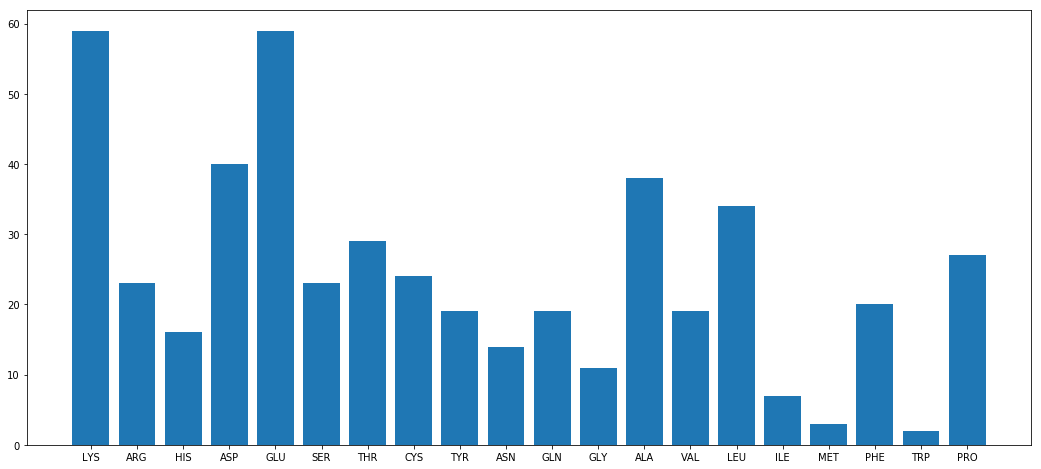

In [7]:
#aromatic_res = ['PHE', 'TRP', 'TYR', 'HIS']
hydrophobic_res = ['ALA', 'ILE', 'LEU', 'VAL', 'GLY', 'PRO','PHE', 'TRP','MET']
polar_res = ['ASN', 'CYS', 'GLN', 'SER', 'THR','TYR']
neg_res = ['ASP', 'GLU']
pos_res = ['ARG', 'HIS', 'LYS']

all_res = [pos_res, neg_res, polar_res, hydrophobic_res]
#Change order of residues before making the bar graph
# (!) Positively charged
# (2) Negatively charged
# (3) Polar residues 
# (4) Hydrophobic residues 


arr_list = []

for row in all_res:
    for i in range(len(c_list)):
        for j in range(len(row)):
            if row[j] == c_list[i][0:3]:
                arr_list.append(c_list[i])

#all_res
#arr_list

f_list = []
fn_list = []
for i in range(len(arr_list)):
    f_list.append(arr_list[i][0:3])
    fn_list.append(int(arr_list[i][5:7]))
    
aa_count = pd.DataFrame(data=f_list, index=None, columns=['Amino_acids'])
new_lf = pd.Series(data=fn_list, index=None)
aa_count['No. of surf. res.'] = new_lf
#aa_count.tail()

#plotting 
#Change order of residues before making the bar graph
# (!) Positively charged
# (2) Negatively charged
# (3) Polar residues 
# (4) Hydrophobic residues 
x = np.arange(20)
plt.figure(figsize=(18,8))
plt.bar(x, aa_count['No. of surf. res.'])
plt.xticks(x,aa_count['Amino_acids'])


In [8]:
aa_count

,Amino_acids,No. of surf. res.
0,LYS,59
1,ARG,23
2,HIS,16
3,ASP,40
4,GLU,59
5,SER,23
6,THR,29
7,CYS,24
8,TYR,19
9,ASN,14


In [9]:
aa_count['No. of surf. res.'].sum()

486

### Now to calculate the fraction of contacts for each type amino acid group

In [10]:
# Read in data from the oputput of wrapper.sh 
pl_25ns_data = pd.read_csv('occ_25ns_p1.txt', sep=" ", header=None, usecols=None ,index_col=None)
pl_25ns_data.columns = ['BSA_res_no','No_of_frames(PLGA trimer)']
#pand_rb = pd.Series(rb, index=None)
pl_25ns_data['BSA_res_des_order'] = pand_rb
pl_25ns_data = pl_25ns_data[["BSA_res_no","BSA_res_des_order","No_of_frames(PLGA trimer)"]]
pl_25ns_data.head()

## Use this occupancy file to organize surface amino acids similar to above code 

,BSA_res_no,BSA_res_des_order,No_of_frames(PLGA trimer)
0,1,ASP,704
1,2,THR,2154
2,3,HIS,2502
3,4,LYS,2502
4,5,SER,2500


In [11]:
apl_list = []

# Some residues don't have any contact with PLGA trimers 
for index, r_pl in pl_25ns_data.iterrows():
    if r_pl['No_of_frames(PLGA trimer)'] != 0:
        apl_list.append(r_pl['BSA_res_des_order'])
        
cpl_l = []
        
for index, r_a in aa_count.iterrows():
    count = 0
    for i in range(len(apl_list)):
        if apl_list[i] == r_a['Amino_acids']:
            count += 1
    cpl_l.append(count)      
        
aa_count['PLGA_trimer_25ns_SR'] = cpl_l
aa_count

,Amino_acids,No. of surf. res.,PLGA_trimer_25ns_SR
0,LYS,59,53
1,ARG,23,16
2,HIS,16,16
3,ASP,40,31
4,GLU,59,50
5,SER,23,15
6,THR,29,29
7,CYS,24,20
8,TYR,19,14
9,ASN,14,10


In [12]:
aa_count['PLGA_trimer_25ns_SR'].sum()

398

In [13]:
aa_count['No. of surf. res.'].sum()

486

In [14]:
# Grouping of residues in Smith et al  
aromatic_res = ['PHE', 'TRP', 'TYR', 'HIS']
hydrophobic_res = ['ALA', 'ILE', 'LEU', 'VAL', 'GLY', 'PRO','PHE', 'TRP','MET']
polar_res = ['ASN', 'CYS', 'GLN', 'SER', 'THR','TYR']
neg_res = ['ASP', 'GLU']
pos_res = ['ARG', 'HIS', 'LYS']

frac_res = [aromatic_res, hydrophobic_res, neg_res, polar_res, pos_res]

co_grpaa = []

for row in frac_res:
    fr_list = []
    for j in range(len(row)):
        for index, r_pl in pl_25ns_data.iterrows():
            if row[j] == r_pl["BSA_res_des_order"]:
                fr_list.append(r_pl["No_of_frames(PLGA trimer)"])
    co_grpaa.append(sum(fr_list))

    
# Now to calculate the number of amino acids in each group type 
tp_cnt = []
    
for row in frac_res:
    nw_l = []
    for j in range(len(row)):
        for index, r_aa in aa_count.iterrows(): 
            if row[j] == r_aa["Amino_acids"]:
                nw_l.append(r_aa['PLGA_trimer_25ns_SR'])
    tp_cnt.append(sum(nw_l))
    

# This data has not been normalized by each amino acid type 
res_aa = {'aa_group_type': ["Aromatic", "Hydrophobic", "Negative", "Polar", "Positive"]}
p25ns_NOT = pd.DataFrame(data=res_aa)
p25ns_NOT['frame_count'] = co_grpaa 
p25ns_NOT['type_of_contact'] = tp_cnt
p25ns_NOT

,aa_group_type,frame_count,type_of_contact
0,Aromatic,62307,49
1,Hydrophobic,143865,134
2,Negative,73533,81
3,Polar,93455,98
4,Positive,80889,85


In [15]:
# Now to calculate the normalized data 

# Total number of surface residues contacted by water in a only BSA/water simulation 
#b_sum = aa_count['No. of surf. res.'].sum()


# In Smith et al., the contacts data has been normalized by the protein
# surface fraction of each amino acid residue type contacted by each 
# polymer surrogate over the portion of the simulation trajectories 

# Some residues don't have any contact with PLGA trimers 
b_sum = p25ns_NOT['type_of_contact'].sum()


norm_list = []

for index, row in p25ns_NOT.iterrows():
    norm_list.append(int(row["frame_count"]/(row["type_of_contact"]/b_sum)))
    
p25ns_NOT["contacts_NORM"] = norm_list 
p25ns_NOT.loc[5] = ["Sum", p25ns_NOT['frame_count'].sum(), p25ns_NOT['type_of_contact'].sum(), p25ns_NOT['contacts_NORM'].sum()]
p25ns_NOT

,aa_group_type,frame_count,type_of_contact,contacts_NORM
0,Aromatic,62307,49,568392
1,Hydrophobic,143865,134,479907
2,Negative,73533,81,405793
3,Polar,93455,98,426269
4,Positive,80889,85,425380
5,Sum,454049,447,2305741


In [16]:
cont_l = []
f_sum = p25ns_NOT['contacts_NORM'].loc[5]

for index, row in p25ns_NOT.iterrows():
    cont_l.append(row['contacts_NORM']/f_sum)
    
p25ns_NOT['frac_cont_norm'] = cont_l
p25ns_NOT

,aa_group_type,frame_count,type_of_contact,contacts_NORM,frac_cont_norm
0,Aromatic,62307,49,568392,0.246512
1,Hydrophobic,143865,134,479907,0.208136
2,Negative,73533,81,405793,0.175992
3,Polar,93455,98,426269,0.184873
4,Positive,80889,85,425380,0.184487
5,Sum,454049,447,2305741,1.000000


([<matplotlib.axis.XTick at 0x2ad3726879e8>,
 <a list of 5 Text xticklabel objects>)

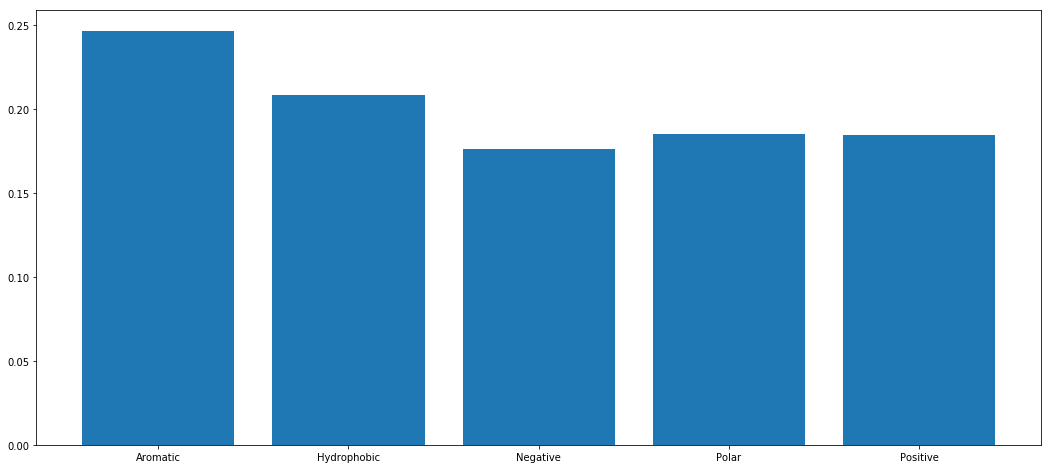

In [17]:
x = np.arange(5)
plt.figure(figsize=(18,8))
plt.bar(x, p25ns_NOT['frac_cont_norm'].loc[0:4])
plt.xticks(x,p25ns_NOT['aa_group_type'].loc[0:4])

### Now to include error bars in bar plot (n = 4)

In [84]:
# Import MDAnalysis
import MDAnalysis as md_A

# Set up the MD simulation in a universe
u_plga = md_A.Universe("../confout.gro","../plga_25ns_p1.xtc")

# Select protein
bsa_res = u_plga.select_atoms("protein")

# Select PLG oligomers 
plga_tri = u_plga.select_atoms("resname PLG")


In [174]:
ct

array([[  18,  957],
       [  19,  958],
       [  19,  948],
       ...,
       [9162, 1419],
       [9163, 1418],
       [9163, 1419]])

In [169]:
# Calculates pairs and distances 
ct, dist = md_A.lib.distances.capped_distance(bsa_res.positions, plga_tri.positions, 4, box=u_plga.dimensions, return_distances=True)

#### Calculate the autocorrelation of a variable in time 

### Residence time calculator from resid.txt file, that's an output from getresid.tcl 

In [ ]:
# RESIDENCE TIME CALCULATOR


# by Parashara Shamaprasad and Karl Oleson and Kayla!

#Run wrapper.sh to get resid.txt

#in you resid.txt file, you will need to first add a space before each line (:1,[#of frames]s/^/ [<-space]))
# -->You will also need to add a blank line to the bottom of the resid.txt document

# This program is intended to read the file produced by Kayla's Occupancy wrapper.sh script
# output the residence (or correlation) time of tannins.

#this script treats the end of the simulation as the end of a binding event (even though it may go on longer if the simulation were extended)

#Double check that the rows in the output file match up with the residues you think they do

#------------#
# INPUT DATA #
#------------#

# specify the input distance file (this needs to be whatever you previosly named it):
in_file = 'residYYY.txt'

# specify the output file for the residence times of the ions (this file will be created)
res_file = 'outputZZZ.txt'

#--------------#
# PROGRAM DATA #
#--------------#

# converts inputfile into list/array
def read_lines(line):
    tokens = line.split()
    lineout = [int(item) for item in tokens]
    return lineout

# converts the distance array into a matrix of on/off states based on
# whether the ion is within the cutoff
def binary_matrix(array):
    output = [[0 for i in range(36)] for j in range(len(array)+1)]
    for row in range(len(array)):
        output[row][0] = row
        for col in range(len(array[row])):
            a = array[row][col]
            output[row][a] = 1
    return output

# finds the residence time for each interaction.
def residence(binlist):
    counting = False # is the counter running?
    output = [["res","times"]] # list of correlation times
    row = 0
    for col in range(1,len(binlist[row])): # for every ion
        output.append([col])
        count = 0
        counting = False
        row = 0
        while row < (len(binlist)): # for every frame
           # counting procedure for each possible scenario
	# is this the first binding event in a string?
            if (counting == False) and (binlist[row][col] == 1):
                counting = True
                count = 1
	# is this the continuation of a binding event
            elif (counting == True) and (binlist[row][col] == 1) and (row < len(binlist) - 2):
                count += 1
	#is this a binding site and at the last row with relevant info
            elif (counting == True) and (binlist[row][col] == 1) and (row < len(binlist) - 1):
                count += 1
                counting = False
                output[col].append(count)
                count = 0
	#is it not binding anymore
            elif (counting == True and binlist[row][col] == 0):
                counting = False
                output[col].append(count)
                count = 0
	#was it previously not binding
            else:
                counting = False
            row += 1
    return output

In [ ]:
# Arranging residence time values for plotting 
f = open('resTime.txt','r')
restimes20=[]
for x in f:
    x = [int(i) for i in x.split()]
    restimes20.append(np.mean(x))
f.close()
restimes20=np.nan_to_num(restimes20)
len(restimes20)
restimesPLA = pd.Series(restimes20)
restimesPLA.sort_values(ascending=False)

In [ ]:
# Create heat map from occupancy text file 
fullTraj = pd.read_table("occ_BSA1ns.txt", delimiter=' ', index_col=0)
data2 = [go.Heatmap(z=fullTraj.T.values.tolist(), colorscale='Viridis')]
py.iplot(data2, filename='BSA_heatmap')